<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-10-25 03:03:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2018-10-25 03:03:34 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [3]:
! ls

loan_train.csv


### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

##### View the Data Types of columns

In [6]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

##### Rename the colum names to lower

In [7]:
# df.columns = map(str.lower, df.columns)
df.columns = [x.lower() for x in df.columns]
df.columns

Index(['unnamed: 0', 'unnamed: 0.1', 'loan_status', 'principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'gender'],
      dtype='object')

### Convert to date time object 

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,unnamed: 0,unnamed: 0.1,loan_status,principal,terms,effective_date,due_date,age,education,gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [11]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

In [12]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

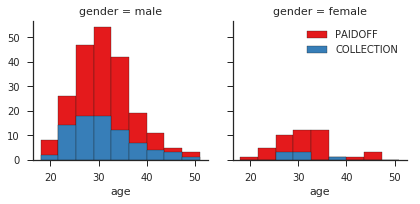

In [13]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

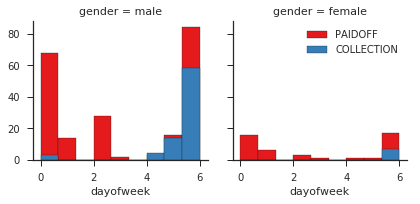

In [14]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [16]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,unnamed: 0,unnamed: 0.1,loan_status,principal,terms,effective_date,due_date,age,education,gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [17]:
print("Total count : {}".format(df['loan_status'].count()))
print(df['gender'].value_counts())
df.groupby(['gender'])['loan_status'].value_counts(normalize=True)

Total count : 346
male      294
female     52
Name: gender, dtype: int64


gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [18]:
df['gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,unnamed: 0,unnamed: 0.1,loan_status,principal,terms,effective_date,due_date,age,education,gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [19]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [20]:
df[['principal','terms','age','gender','education']].head()

,principal,terms,age,gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [21]:
Feature = df[['principal','terms','age','gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,principal,terms,age,gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [22]:
X = Feature
X[0:5]

,principal,terms,age,gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [23]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [24]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

### Train Test Split  
Let's split the data in to Training and Testing set

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

#### Function to plot Confusion Matrix

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [29]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.67142857,  0.65714286,  0.71428571,  0.68571429,  0.75714286,
        0.71428571,  0.78571429,  0.75714286,  0.75714286])

### Find the best K

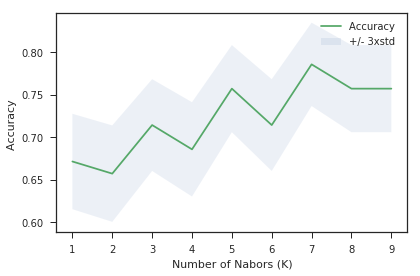

In [30]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

### Create the model with best K
##### Best accuracy was with k = 7

In [31]:
# Create and Train the Model on Training Data Set
k = 7
#Train Model
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

## Decision Tree

In [32]:
# Create and Train the Model on Training Data Set
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Support Vector Machine

In [33]:
# Create and Train the Model on Training Data Set
from sklearn import svm
clf = svm.SVC(kernel='rbf',probability=True)
clf.fit(X_train, y_train) 
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Logistic Regression

In [34]:
# Create and Train the Model on Training Data Set
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Model Evaluation using Test set

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2018-10-25 03:07:24--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2018-10-25 03:07:24 (739 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.shape
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


##### Perform preprocessing steps on the training data

In [38]:
# Rename columns to lowercase
# test_df.columns = map(str.lower, test_df.columns)
test_df.columns = [x.lower() for x in test_df.columns]

# Change the string to date types
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# Get a new column indication weekend
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Change gender to numerical value
test_df['gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

# View the date set
test_df.head()

,unnamed: 0,unnamed: 0.1,loan_status,principal,terms,effective_date,due_date,age,education,gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


#### Create the Feature for Training

In [39]:
testFeature = test_df[['principal','terms','age','gender','weekend']]
testFeature = pd.concat([testFeature,pd.get_dummies(test_df['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)
testFeature.shape
testFeature.head()

,principal,terms,age,gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


#### Convert the Model to scaler

In [40]:
X_test= preprocessing.StandardScaler().fit(testFeature).transform(testFeature)
y_test = test_df.loan_status.values

print(X_test[0:5])
print(y_test[0:5])

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]]
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


# Import Libraries to measure the accuraccy of the Model

##### View the Accuracy of Model
Based on the count of each section, we can calculate precision and recall of each label:


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is true positive rate. It is defined as: Recall =  TP / (TP + FN)

    
So, we can calculate precision and recall of each class.

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. 

The F1score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

In [41]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

## K Nearest Neighbor(KNN)
 

In [42]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((276, 8), (276,), (54, 8), (54,))

In [43]:
# Get the Prediction from Model
yhat_k = neigh.predict(X_test)
yhat_prob = neigh.predict_proba(X_test)

print(y_test[0:5])
print(yhat_k[0:5])
print(yhat_prob[0:5])

len(X_test)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION']
[[ 0.          1.        ]
 [ 0.42857143  0.57142857]
 [ 0.57142857  0.42857143]
 [ 0.71428571  0.28571429]
 [ 0.71428571  0.28571429]]


54

#### Create a list to save the Metrics evaluation

In [44]:
acceval_df = pd.DataFrame(data={"Jaccard":[0,0,0,0,],"F1-Score":[0,0,0,0,],"Log Loss":[0,0,0,0,]}, index=['KNN','Decision','SVM','Logistic Regression'])
acceval_df.head()

,F1-Score,Jaccard,Log Loss
KNN,0,0,0
Decision,0,0,0
SVM,0,0,0
Logistic Regression,0,0,0


#### Accuracy evaluation
In multilabel classification, __accuracy classification score__ function computes subset accuracy. This function is equal to the jaccard_similarity_score function. Essentially, it calculates how match the actual labels and predicted labels are in the test set.

In [45]:
acceval_df.iloc[0] = [round(jaccard_similarity_score(y_test, yhat_k),2),round(f1_score(y_test, yhat_k, average='weighted'),2),"NA"]
acceval_df.head()

print("Train set Accuracy: ", accuracy_score(y, neigh.predict(X)))
print("Test set Accuracy: ", accuracy_score(y_test, yhat_k))

Train set Accuracy:  0.803468208092
Test set Accuracy:  0.666666666667


             precision    recall  f1-score   support

 COLLECTION       0.25      0.14      0.18        14
    PAIDOFF       0.74      0.85      0.79        40

avg / total       0.61      0.67      0.63        54

Confusion matrix, without normalization
[[ 2 12]
 [ 6 34]]


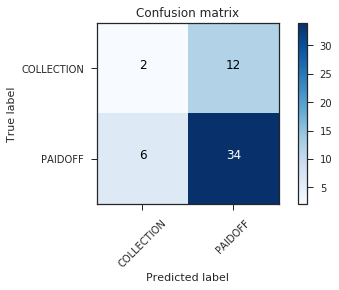

In [46]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_k, labels=['COLLECTION', 'PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_k))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

## Decision Tree

In [47]:
predTree = loanTree.predict(X_test)
predTree_prob = loanTree.predict_proba(X_test)

print(predTree [0:5])
print(y_test [0:5])
print(predTree_prob[0:5])


['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
[[ 0.   1. ]
 [ 0.   1. ]
 [ 0.   1. ]
 [ 0.5  0.5]
 [ 0.5  0.5]]


In [48]:
acceval_df.iloc[1] = [round(jaccard_similarity_score(y_test, predTree),2),round(f1_score(y_test, predTree, average='weighted'),2),"NA"]
acceval_df.head()

print("Train set Accuracy: ", accuracy_score(y, neigh.predict(X)))
print("Test set Accuracy: ", accuracy_score(y_test, predTree))

Train set Accuracy:  0.803468208092
Test set Accuracy:  0.722222222222


#### Compute the Confusion Matrix

             precision    recall  f1-score   support

 COLLECTION       0.48      0.71      0.57        14
    PAIDOFF       0.88      0.72      0.79        40

avg / total       0.77      0.72      0.74        54

Confusion matrix, without normalization
[[10  4]
 [11 29]]


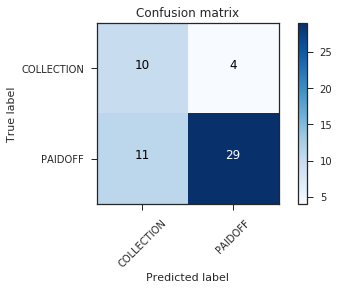

In [49]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree, labels=['COLLECTION', 'PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, predTree))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

## Support Vector Machine

In [50]:
yhat_svm = clf.predict(X_test)
yhat_svm_prob = clf.predict_proba(X_test)
print('')

print(yhat_svm [0:5])
print(y_test [0:5])
print(yhat_svm_prob[0:5])


['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
[[ 0.18  0.82]
 [ 0.23  0.77]
 [ 0.26  0.74]
 [ 0.35  0.65]
 [ 0.51  0.49]]


In [51]:
acceval_df.iloc[2] = [round(jaccard_similarity_score(y_test, yhat_svm),2),round(f1_score(y_test, yhat_svm, average='weighted'),2),"NA"]
acceval_df.head()

print("Train set Accuracy: ", accuracy_score(y, loanTree.predict(X)))
print("Test set Accuracy: ", accuracy_score(y_test, yhat_svm))

Train set Accuracy:  0.719653179191
Test set Accuracy:  0.796296296296


#### Compute the Confusion Matrix

             precision    recall  f1-score   support

 COLLECTION       0.80      0.29      0.42        14
    PAIDOFF       0.80      0.97      0.88        40

avg / total       0.80      0.80      0.76        54

Confusion matrix, without normalization
[[ 4 10]
 [ 1 39]]


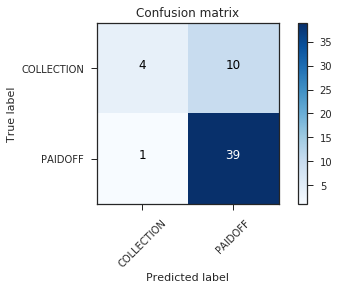

In [52]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_svm, labels=['COLLECTION', 'PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_svm))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

## Logistic Regression

In [53]:
yhat_lr = LR.predict(X_test)
yhat_lr_prob = LR.predict_proba(X_test)

print(y_test[0:5])
print(yhat_lr[0:5])
print(yhat_lr_prob[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']
[[ 0.25  0.75]
 [ 0.41  0.59]
 [ 0.43  0.57]
 [ 0.51  0.49]
 [ 0.46  0.54]]


In [54]:
acceval_df.iloc[3] = [round(jaccard_similarity_score(y_test, yhat_lr),2),round(f1_score(y_test, yhat_lr, average='weighted'),2),round(log_loss(y_test, yhat_lr_prob),2)]
acceval_df.head()

# print("Train set Accuracy: ", accuracy_score(y, loanTree.predict(X)))
# print("Test set Accuracy: ", accuracy_score(y_test, yhat_lr))

,F1-Score,Jaccard,Log Loss
KNN,0.67,0.63,NA
Decision,0.72,0.74,NA
SVM,0.80,0.76,NA
Logistic Regression,0.74,0.66,0.57


             precision    recall  f1-score   support

 COLLECTION       0.50      0.07      0.12        14
    PAIDOFF       0.75      0.97      0.85        40

avg / total       0.69      0.74      0.66        54

Confusion matrix, without normalization
[[ 1 13]
 [ 1 39]]


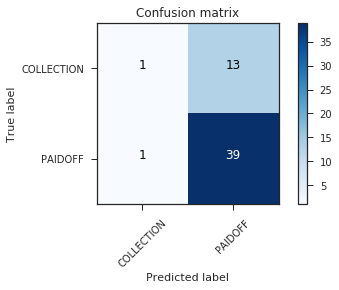

In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_lr, labels=['COLLECTION', 'PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_lr))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [56]:
acceval_df.head()

,F1-Score,Jaccard,Log Loss
KNN,0.67,0.63,NA
Decision,0.72,0.74,NA
SVM,0.80,0.76,NA
Logistic Regression,0.74,0.66,0.57


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67    | 0.63     | NA      |
| Decision Tree      | 0.72    | 0.74     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.57    |

## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)


<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>